# Machine Learning on ATLAS Open Data

In [ ]:
import sys
import pickle
import json
import numpy as np
import pandas as pd
import os.path
from IPython.display import Image
from IPython.core.display import HTML 

In [ ]:
import uproot
import vector
import awkward

In [ ]:
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math
# SKL
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
import time

In [ ]:
import tensorflow as tf

In [ ]:
import glob

In [ ]:
from keras.models import Sequential, load_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.python.client import device_lib 

In [ ]:
import xgboost as xgb

In [ ]:
import sys
import logging
logging.basicConfig(
                    format="%(message)s",
                    level=logging.ERROR,
                    stream=sys.stdout)
logging.getLogger('matplotlib.font_manager').disabled = True

Set the following variable to 1 if you want to try to use the GPU, otherwise it should be set to -1

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Ok, let's start by reading in some data after we've loaded all of the modules above. The dataframe can in principle be any data frame with a set of features, but this examples will use a data frame created from the ATLAS Open data using the example in the NtupToDF notebook which you can find in [zpath github](https://github.uio.no/zpath/software/tree/master/Notebooks/ATLASOpenData/13TeV) (and which should also be accessible from the FYS5555 interactive session in Galaxy). But for this tutorial you would not need to bother about this since we already created a data frame which is directly accessible from the local disk.

In [ ]:
df = pd.read_hdf("/storage/shared/data/2lep_df_forML.hdf5")

The signal simulations are put in a separate hdf5 file, but put it into (concatenate) the same data frame

In [ ]:
df = pd.concat([df,pd.read_hdf("/storage/shared/data/2lep_df_forML_signal.hdf5")])

Have a look at the first five events (rows) data frame (it contains 21 variables/features). Among them the background/signal category and weights for scaling the simulation to data.

In [ ]:
df.head()

... and here are all the features

In [ ]:
df.columns

And this is how many features and events we have

In [ ]:
print("Number of events = %i"%df.shape[0])
print("Number of features = %i"%df.shape[1])

Load some home made tools, mainly for reading ROOT files. Feel free to use you own.

In [ ]:
from CommonTools import reconstructionError,relativeErrorByFeature, printResults
from helpFuncs import *

## Select the signal model
The data frame contains events from all the various signal models available in the 2Lep data set. When we will train our network below we obviously only want to consider one of them. Let's first have a look on the available signal models in the data frame.

In [ ]:
df[df['isSignal'] == 1]["category"].unique()

In [ ]:
bkg_categories = df[df['isSignal'] == 0]["category"].unique()

 Let's pick the SUSY chargino-chargino prouction decaying via leptons (SUSYC1C1). I.e. the following process.

In [ ]:
Image(url= "https://gitlab.cern.ch/atlas-phys-susy-wg/feynmangraphs/-/wikis/uploads/C1C1-llvvN1N1-slsl.png", width=300, height=300)

Put the signal model we want into a new data frame

In [ ]:
sig_df = df[df['category'] == 'SUSYC1C1']

and similarly for the background (removing all the signal models)

In [ ]:
bkg_df = df[df['isSignal'] == 0]

In [ ]:
bkg_df = df[df['lep_pt1'] < 2000]
bkg_df = df[df['met'] < 2000]

We now have the background and signal samples we want to use in our machine learning studies below. Let's check the sizes of our samples

In [ ]:
print("*"*30)
print("Background")
print("*"*30)
print("Number of events = %i"%bkg_df.shape[0])
print("Number of features = %i"%bkg_df.shape[1])
print("*"*30)
print("Signal")
print("*"*30)
print("Number of events = %i"%sig_df.shape[0])
print("Number of features = %i"%sig_df.shape[1])

## Machine Learning
Ok, finally we're ready to start cracking with the ML! First let's see if we can see the two (or at least one) of the GPUS available on the hepp02 and 03 machines.

In [ ]:
gpu_available = tf.test.is_gpu_available();
if gpu_available:
    print("Great! You found the GPU!!! Let's go hunt some SUSY :-)")
else:
    print("Did not find any GPUs. Too bad.")
#print(device_lib.list_local_devices()) 

We also needs to drop some features (such as the isSignal, weights and category) since we do not want to let the network train on these

In [ ]:
drop_col = ['category','isSignal','weight']
sig_df.drop(labels=drop_col,axis=1,inplace=True)
bkg_df.drop(labels=drop_col,axis=1,inplace=True)

Check that it worked, the shape should now have less features and put them in a list (to be used when plotting later)

In [ ]:
sig_df.shape
featuresList = sig_df.columns

Lets first split the background into train and test samples

In [ ]:
X_train_ref, X_test_ref = train_test_split(bkg_df, test_size=0.2, random_state=42)

and do the same for the signal

In [ ]:
X_train_sub, X_test_sub = train_test_split(sig_df, test_size=0.2, random_state=42)

Combining the signal and background

In [ ]:
X_train = np.concatenate((X_train_ref,X_train_sub),0)                                                                                                                                                                                                                               
X_test = np.concatenate((X_test_ref,X_test_sub),0) 

Y_train_ref = np.zeros(X_train_ref.shape[0])                                                                                                                                                                                                                                                   
Y_train_sub = np.ones(X_train_sub.shape[0])      
Y_train = np.concatenate((Y_train_ref,Y_train_sub),0) 

Y_test_ref = np.zeros(X_test_ref.shape[0])                                                                                                                                                                                                                                                   
Y_test_sub = np.ones(X_test_sub.shape[0])      
Y_test = np.concatenate((Y_test_ref,Y_test_sub),0) 

In [ ]:
# Feature scaling                                                                                                                                                                                                                                                                    
min_max_scaler = preprocessing.MinMaxScaler()                                                                                                                                                                                                                                        
X_train = min_max_scaler.fit_transform(X_train)                                                                                                                                                                                                                                      
X_test = min_max_scaler.transform(X_test)        

In [ ]:
# Special feature scaling for autoencoder (since it is only trained on the reference)                                                                                                                                                                                                
min_max_scaler_ae = preprocessing.MinMaxScaler()                                                                                                                                                                                                                                     
X_train_ref_ae = min_max_scaler_ae.fit_transform(X_train_ref)                                                                                                                                                                                                                        
X_test_ref_ae = min_max_scaler.transform(X_test_ref)                                                                                                                                                                                                                                 
X_test_sub_ae = min_max_scaler.transform(X_test_sub)         

Let's see what we just did with our features

In [ ]:
max(bkg_df['met'])

In [ ]:
isRef = True
nbins = 100
feature = 'lep_eta1'

nf = np.where(bkg_df.columns.values == feature)[0][0]
a = np.array([X_train_ref_ae.item((i,nf)) for i in range(X_train_ref_ae.shape[0])])

figAE, axsAE = plt.subplots(2, 1)
axAE1, axAE2 = axsAE.ravel()

ns1, bins1, patches1 = axAE1.hist(bkg_df[feature], bins=nbins, facecolor='blue' if isRef else 'green', histtype='stepfilled',label='ref' if isRef else 'subj')
ns2, bins2, patches2 = axAE2.hist(a,       bins=nbins, facecolor='blue' if isRef else 'green', histtype='stepfilled',label='ref (scaled)' if isRef else 'subj (scaled)')

axAE1.legend()
axAE2.legend()
axAE2.set_xlabel(feature) 
plt.yscale('log')

# Autoencoder
An autoencoder is a neural network that is trained to attempt to copy its input to its output. Internally, it has a hidden layer that describes a code used to represent the input. The network may be viewed as consisting of two parts: an encoder function $h = f(x)$ and a decoder that produces a reconstruction $r = g(h)$ as illustrated below

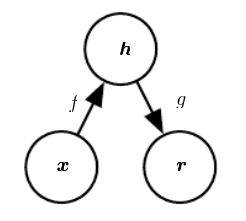

If an autoencoder succeeds in simply learning to set $g(f(x)) = x$ everywhere, then it is not especially useful. Instead, autoencoders are designed to be unable to learn to copy perfectly. Usually they are restricted in ways that allow them to copy only approximately, and to copy only input that resembles the training data. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data.

For more information on autoencoders please have a look at the [Deep Learning Book](https://www.deeplearningbook.org/contents/autoencoders.html).

In the context of this tutorial we are interested in training an autoencoder which can find useful properties of the SM background. When the trained autoencoder later it is applied on some new physics model the hope is that it will have problems to decode it. This will result in events not looking like bakcgorund will have large reconstruction errors when the NN tries to decode them, while events that are background-like will have small errors. This then allows to discriminate between signal and background.

Let's first start to build a sequential model (defines the layers of the NN). More information on sequential models can be found [here](https://keras.io/guides/sequential_model/) 

In [ ]:
class AnomalyDetector(Model):
  nf = 10
  def __init__(self,nf):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(18, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(18, activation="relu")
    ])  
    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(nf, activation="sigmoid"),
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
from keras.layers import Dense, Activation
start = time.time()  
nfeat = X_train_ref_ae.shape[1]
print("Number of features used in traing %i"%nfeat)
# using the class above
#ae = AnomalyDetector(nfeat)
ae = Sequential()   
ae.add(Dense(units=8, input_dim=nfeat))                                                                                                                                                                      
ae.add(Activation("relu"))                                                                                                                                                                                 
ae.add(Dense(units=nfeat, input_dim=8))                                                                                                                                                                      
ae.add(Activation("linear"))              

In [ ]:
ae.summary()

In [ ]:
ae.compile(loss="mean_squared_error",optimizer="sgd")
history = ae.fit(X_train_ref_ae,X_train_ref_ae,epochs=1,batch_size=1000,validation_data=(X_test_ref_ae, X_test_ref_ae))                

In [ ]:
ae.save_weights("autoencoder_newmodel_50epochs.h5")   

In [ ]:
#ae = Sequential()  
ae.load_weights('/storage/shared/data/autoencoder_newmodel_50epochs.h5')  # load model weights

In [ ]:
# Testing
#predicted_same_ae = ae.predict(X_train_ref_ae)
predicted_diff_ae = ae.predict(X_test_ref_ae)
predicted_sub_ae = ae.predict(X_test_sub_ae)
# Reconstruction error
#rec_errors_same_ae = reconstructionError(X_train_ref_ae,predicted_same_ae)
rec_errors_diff_ae = reconstructionError(X_test_ref_ae,predicted_diff_ae)
rec_errors_sub_ae = reconstructionError(X_test_sub_ae,predicted_sub_ae)

# Investigating the results
Let's plot some useful results of the traines classifier when testing it on the test input.

In [ ]:
y_pos = np.arange(len(bkg_df.columns))
bins = np.linspace(-0.5, 1.5, 250)

First plot the reconstruction error of the test reference and subject data sets

In [ ]:
# Outputs
figAE, axsAE = plt.subplots(2, 1);
axAE1, axAE2 = axsAE.ravel();
figAE.set_size_inches(10,15);
for ax in axAE1, axAE2:
    ax.set_ylabel("Events")
    ax.set_xlabel("log10(Autoencoder reconstruction error)")
#axAE1.hist(rec_errors_same_ae, bins, facecolor='blue', alpha=0.4, histtype='stepfilled');
#axAE1.hist(rec_errors_diff_ae, bins, facecolor='green', alpha=0.4, histtype='stepfilled');
axAE2.hist(rec_errors_diff_ae, bins, facecolor='green', alpha=0.4, histtype='stepfilled');
axAE2.hist(rec_errors_sub_ae, bins, facecolor='red', alpha=0.4, histtype='stepfilled');
axAE1.set_xscale('log')
axAE1.set_yscale('log')
axAE2.set_yscale('log')

And then look at the ROC-curve

In [ ]:
# ROC
Y_ref = np.zeros(X_test_ref.shape[0]).reshape(X_test_ref.shape[0],1);
Y_sub = np.ones(X_test_sub.shape[0]).reshape(X_test_sub.shape[0],1);
Y_ROC = np.concatenate((Y_ref,Y_sub),0);
rec_errors_ROC = np.concatenate((rec_errors_diff_ae,rec_errors_sub_ae),0)
fpr, tpr, thresholds = roc_curve(Y_ROC, rec_errors_ROC, pos_label=1)
ae_auc = roc_auc_score(Y_ROC, rec_errors_ROC)
figRocAE, axRocAE = plt.subplots()
figRocAE.set_size_inches(10,15)
axRocAE.plot(fpr, tpr, label='ROC curve')
axRocAE.plot([0, 1], [0, 1], 'k--')
axRocAE.set_xlim([0.0, 1.0])
axRocAE.set_ylim([0.0, 1.05])
axRocAE.set_xlabel('False Anomaly Rate')
axRocAE.set_ylabel('True Anomaly Rate')
axRocAE.text(0.4,0.2,"AUC = %.4f" % ae_auc,fontsize=15)
axRocAE.set_title("Autoencoder ROC")

And finally the variable importance

In [ ]:
# Variable importance
rec_errors_varwise_sub = relativeErrorByFeature(X_test_sub_ae,predicted_sub_ae)
figVarAE, axVarAE = plt.subplots(1,1)
figVarAE.set_size_inches(10,15)
axVarAE.barh(y_pos, 100*rec_errors_varwise_sub, align='center', alpha=0.4)
axVarAE.set_ylim([0,len(featuresList)])
axVarAE.set_yticks(y_pos)
axVarAE.set_yticklabels(featuresList,fontsize=8)
axVarAE.set_xlabel('Relative importance, %')
axVarAE.set_title("Estimated variable importance using outputs (autoencoder)")
#pdf_pages.savefig(figVarAE)

# Plotting R&D (Not yet working)

In [ ]:
mc_mll = []
mc_weights = []
mc_colors = []
mc_labels = []

data_mll = []
data_mll_errors = []

var = "met"
top = -999

nmax = 1000
nmin = 0
binw = 20

data_x = []
if not ((nmax-nmin)/binw).is_integer():
    print("ERROR \t Limits and bin width are not compatible")
print(int((nmax-nmin)/binw)+1)
bins = [nmin + (x*binw) for x in range(int((nmax-nmin)/binw)+1)]
for i in range(len(bins)-1):
    #print(bins[i])
    data_x.append(bins[i]+(bins[i+1]-bins[i])/2)
for s in bkg_categories:
    if s == "Data":
        data_mll,_ = np.histogram(X_data.as_matrix(columns=X_data.columns[X_data.columns.get_loc(var):X_data.columns.get_loc(var)+1])/1000., bins=bins)
        data_mll_errors = np.sqrt(data_mll)
    else:
        df = bkg_df.loc[df['category'] == s]
        mc_mll.append(rslt_df.as_matrix(columns=rslt_df.columns[rslt_df.columns.get_loc(var):rslt_df.columns.get_loc(var)+1])/1000.)
        mc_weights.append(rslt_df.as_matrix(columns=rslt_df.columns[rslt_df.columns.get_loc("wgt"):rslt_df.columns.get_loc("wgt")+1]))
        mc_colors.append(bkg_plot_dic[s])
        mc_labels.append(s)
        if np.amax(mc_mll[-1]) > top:
            top = np.amax(mc_mll[-1])
        del [rslt_df]
    print(s)

In [ ]:
figure(num=None, figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')
plt.hist(mc_mll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels); #weights=mc_weights,
plt.errorbar( x=data_x, y=data_mll, yerr=data_mll_errors, fmt='ko', label='Data')
plt.yscale('log')
plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
plt.xlabel(r'$M_{ll}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

plt.ylim(bottom=1,top=top*10)

ax = plt.gca()
plt.text(0.45,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
plt.text(0.45,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
plt.text(0.45,0.90,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=10\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)


plt.legend()